In [1]:
from fastai.fastai.text import *
import pickle

In [2]:
chunksize=24000

In [4]:
chunksize

24000

In [5]:
pd.set_option('display.max_colwidth', -1)
df_tes = pd.read_csv('Transcript_Data/lm/lm_test.txt', header=None)
df_tes.iloc[0].values

array([" -text-  crlf      crlf      crlf     I would now like to turn the call over to Ms. Lily Arteaga, VP of Investor Relations for ILG. Ma'am, you may begin your conference. crlf      crlf      crlf      crlf      crlf     I want to remind you that on our call we will discuss our outlook for future performance and other items that are not historical facts. These forward-looking statements typically are preceded by words such as, we expect, we believe, we anticipate or similar statements. These forward-looking statements are subject to risks, assumptions and uncertainties and our actual results may differ materially from these forward-looking statements in the views expressed today. crlf     Some of these risks have been set forth in our fourth quarter 2017 press release issued earlier today in our Form 10-K and another periodic reports filed with the SEC. In addition, ILG disclaims any intent or obligation to update these forward-looking statements, except as expressly required by 

In [6]:
# fix numbers in the text

def fixup(x):
    x = re.sub(r'(,[\d][\d]{2})', ' 000 ', x) # $605,100,100 -> $605 000 000
    
    x = re.sub('([\D][0]\.[1-9])[\d]+', r'\1', x)  # 0.59 -> 0.5
    x = re.sub(r'([\D][1-9])\.[\d]+', r'\g<1>', x)  # 3.6 -> 3
    x = re.sub(r'([\D^\.][1][0-9])\.[\d]+', r'\g<1>', x)  # 19.6 -> 19
    x = re.sub(r'([\D^\.][2-9])[0-9](\.[\d]+)?([\D])', r'\g<1>0\g<3>', x)  # 26.25 -> 26
    x = re.sub(r'([\D^\.][\d])[\d]{2}(\.[\d]+)?([\D])', r'\g<1>00\g<3>', x)  # $158.4 million -> $100 million
    
    x = re.sub(r'\$', r' $ ', x)
    x = re.sub(r'\%', r' % ', x)
    
    x = x.replace('pppp', 'xppx')
    
    return x

In [7]:
# tokenize

def get_texts(df):
    texts = df[0].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

In [8]:
# tokenized text to list

def get_all(df):
    tok = []
    for i, r in enumerate(df):
        print(i)
        tok_ = get_texts(r)
        tok += tok_;
    return tok

In [9]:
df_trn = pd.read_csv('Transcript_Data/lm/lm_train.txt', header=None, chunksize=chunksize)
df_tes = pd.read_csv('Transcript_Data/lm/lm_test.txt', header=None, chunksize=chunksize)

In [10]:
# takes a long time to generate these tokens and sometimes is incomplete!

tok_trn = get_all(df_trn)
tok_tes = get_all(df_tes)

0
1
2
3
0


In [15]:
# tok_tes[0][:100]

In [11]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)
# freq.most_common()[-50:]

[('the', 12776710),
 ('.', 11688049),
 (',', 9993873),
 ('to', 8042040),
 ('and', 7721203),
 ('of', 7510013),
 ('in', 6736467),
 ('our', 5771969),
 ('we', 5557395),
 ('crlf', 4622840),
 ('a', 3657899),
 ('for', 3036713),
 ('quarter', 2839186),
 ('$', 2627922),
 ('-', 2595141),
 ('%', 2406647),
 ('that', 2360086),
 ('million', 2324364),
 ('year', 2291429),
 ('as', 2168148)]

In [12]:
# going higher (overfitting) or lower (to 40K is not bad)

max_vocab = 60000
min_freq = 2

In [13]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [14]:
# default dict assigns 0 as default which is for _unk_

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [19]:
itos[0], itos[1], itos[10], itos[100]

('_unk_', '_pad_', 'we', 'cost')

In [20]:
# converting the tokenized text to index arrays - unknown?

trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
tes_lm = np.array([[stoi[o] for o in p] for p in tok_tes])

In [ ]:
np.save('results_rakesh/tok_inds_npy/lm/ids_train.npy', trn_lm)
np.save('results_rakesh/tok_inds_npy/lm/ids_test.npy', tes_lm)
pickle.dump(itos, open('results_rakesh/tok_inds_npy/lm/itos.pkl', 'wb'))

In [18]:
1+1

2

# load pre-trained wiki language model

In [21]:
trn_lm = np.load('results_rakesh/tok_inds_npy/lm/ids_train.npy')
tes_lm = np.load('results_rakesh/tok_inds_npy/lm/ids_test.npy')
itos = pickle.load(open('results_rakesh/tok_inds_npy/lm/itos.pkl', 'rb'))

In [22]:
vs=len(itos)
vs,len(trn_lm)

(60002, 80399)

In [23]:
em_sz,nh,nl = 400,1150,3

In [24]:
# loading the model built by fast ai on wikipedia dataset
# fwd_wt103 is what they used - can we use bwd?
# difference between fwd_wt103 and encoder is the first part vs. fwd_wt103 includes decoder

PRE_PATH = Path('results_rakesh/fastai_models/wt103')
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [25]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [26]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [27]:
# this loads the indexing as used by the fastai model

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [28]:
itos2[:10], len(itos2)

(['_unk_', '_pad_', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a'], 238462)

In [29]:
# converting to our word index and copying the embeddings for encoder weights

new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [30]:
# what is T? and all weights are initialized to wgts??
# T is pytorch tensor
# wgts is a dict with names of 3 diff tensors
# remaining weights dont need to change in the NN

wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

# train new language model

In [31]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [32]:
# what exactly does this block do / load?
# the loader takes care of splitting into batches
# md is the model data object

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
tes_dl = LanguageModelLoader(np.concatenate(tes_lm), bs, bptt)
md = LanguageModelData("results_rakesh/nn_models/", 1, vs, trn_dl, tes_dl, bs=bs, bptt=bptt)

In [33]:
# dropout diff values for LM and classifier

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [34]:
# this initializes the language model or the learning rate?

learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]   # is this the loss? not sure maybe print out
learner.freeze_to(-1)

In [35]:
learner.model.load_state_dict(wgts)

In [36]:
lr=1e-3
lrs = lr

In [ ]:
learner

In [38]:
# Results of Rakesh's language model run

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

  6%|▌         | 4850/79611 [09:51<2:32:05,  8.19it/s, loss=4.52]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 16%|█▌        | 12367/79611 [25:13<2:17:10,  8.17it/s, loss=4.17]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 24%|██▎       | 18811/79611 [38:23<2:04:06,  8.16it/s, loss=4.01]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 58%|█████▊    | 46353/79611 [1:34:17<1:07:39,  8.19it/s, loss=3.8] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 67%|██████▋   | 53674/79611 [1:49:08<52:44,  8.20it/s, loss=3.79]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 90%|████████▉ | 71464/79611 [2:25:15<16:33,  8.20it/s, loss=3.8] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 98%|█████████▊| 78386/79611 [2:39:18<02:29,  8.20it/s, loss=3.81]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
# Results of Yifan's language model run

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                           
    0      3.782169   3.576808   0.340486  



[array([3.57681]), 0.3404862690212228]

In [39]:
learner.save('lm_last_ft')

In [40]:
print ("Everything is saved")

Everything is saved


In [ ]:
1+1

In [43]:
learner.load('lm_last_ft')

In [44]:
learner.unfreeze()

In [45]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

  6%|▌         | 4632/79611 [10:34<2:51:02,  7.31it/s, loss=3.45]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 15%|█▌        | 12163/79611 [27:41<2:33:34,  7.32it/s, loss=3.4] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 24%|██▍       | 19461/79611 [44:24<2:17:14,  7.30it/s, loss=3.34]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 34%|███▍      | 26953/79611 [1:01:25<1:59:59,  7.31it/s, loss=3.48]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 43%|████▎     | 34399/79611 [1:18:26<1:43:06,  7.31it/s, loss=3.46]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 69%|██████▉   | 54884/79611 [2:04:52<56:15,  7.32it/s, loss=3.48]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 78%|███████▊  | 62348/79611 [2:21:46<39:15,  7.33it/s, loss=3.5] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 88%|████████▊ | 69828/79611 [2:38:47<22:14,  7.33it/s, loss=3.44]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 97%|█████████▋| 77335/79611 [2:55:49<05:10,  7.33it/s, loss=3.43]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



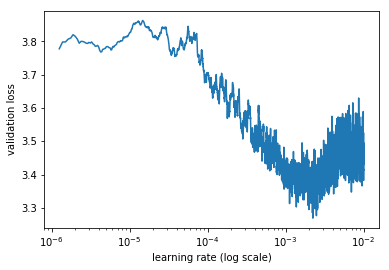

In [46]:
learner.sched.plot()

In [47]:
learner.save('lm_last_ft2')

In [ ]:
1+1

In [ ]:
# learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=2)

  4%|▍         | 3135/79611 [07:10<2:55:13,  7.27it/s, loss=3.57]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 13%|█▎        | 10602/79611 [24:11<2:37:24,  7.31it/s, loss=3.45]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 23%|██▎       | 18112/79611 [41:19<2:20:20,  7.30it/s, loss=3.45]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 32%|███▏      | 25572/79611 [58:19<2:03:14,  7.31it/s, loss=3.36]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 41%|████      | 32413/79611 [1:14:05<1:47:52,  7.29it/s, loss=3.26]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 50%|█████     | 39829/79611 [1:31:03<1:30:57,  7.29it/s, loss=3.24]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 59%|█████▉    | 47266/79611 [1:48:00<1:13:54,  7.29it/s, loss=3.24]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 69%|██████▊   | 54727/79611 [2:05:00<56:50,  7.30it/s, loss=3.28]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 78%|███████▊  | 62161/79611 [2:21:59<39:51,  7.30it/s, loss=3.25]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 87%|████████▋ | 69589/79611 [2:38:58<22:53,  7.30it/s, loss=3.22]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 97%|█████████▋| 76855/79611 [2:55:34<06:17,  7.30it/s, loss=3.23]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  6%|▌         | 4642/79611 [10:35<2:51:02,  7.31it/s, loss=3.18]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 15%|█▌        | 12134/79611 [27:38<2:33:41,  7.32it/s, loss=3.23]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 25%|██▍       | 19585/79611 [44:35<2:16:38,  7.32it/s, loss=3.2] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 34%|███▍      | 27080/79611 [1:01:38<1:59:33,  7.32it/s, loss=3.2] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 43%|████▎     | 34549/79611 [1:18:41<1:42:38,  7.32it/s, loss=3.17]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 52%|█████▏    | 41217/79611 [1:34:02<1:27:35,  7.31it/s, loss=3.16]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61%|██████    | 48710/79611 [1:51:16<1:10:35,  7.30it/s, loss=3.19]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 71%|███████   | 56234/79611 [2:08:31<53:25,  7.29it/s, loss=3.14]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 80%|███████▉  | 63680/79611 [2:25:29<36:23,  7.29it/s, loss=3.15]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 89%|████████▉ | 71157/79611 [2:42:32<19:18,  7.30it/s, loss=3.15]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 96%|█████████▌| 76480/79611 [2:54:41<07:09,  7.30it/s, loss=3.14]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 99%|█████████▊| 78548/79611 [2:59:24<02:25,  7.30it/s, loss=3.19]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  5%|▌         | 4310/79611 [09:48<2:51:20,  7.32it/s, loss=3.11]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  8%|▊         | 6389/79611 [14:34<2:46:56,  7.31it/s, loss=3.18]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 15%|█▍        | 11682/79611 [26:38<2:34:56,  7.31it/s, loss=3.21]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 17%|█▋        | 13757/79611 [31:23<2:30:16,  7.30it/s, loss=3.2] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 24%|██▍       | 19090/79611 [43:32<2:18:03,  7.31it/s, loss=3.18]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 27%|██▋       | 21177/79611 [48:18<2:13:16,  7.31it/s, loss=3.21]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 33%|███▎      | 26563/79611 [1:00:32<2:00:54,  7.31it/s, loss=3.19]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 36%|███▌      | 28665/79611 [1:05:20<1:56:07,  7.31it/s, loss=3.21]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 43%|████▎     | 33996/79611 [1:17:30<1:44:00,  7.31it/s, loss=3.13]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 45%|████▌     | 36116/79611 [1:22:19<1:39:09,  7.31it/s, loss=3.24]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 52%|█████▏    | 41433/79611 [1:34:27<1:27:01,  7.31it/s, loss=3.11]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 55%|█████▍    | 43554/79611 [1:39:17<1:22:12,  7.31it/s, loss=3.18]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61%|██████▏   | 48847/79611 [1:51:19<1:10:06,  7.31it/s, loss=3.1] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 64%|██████▍   | 50946/79611 [1:56:06<1:05:19,  7.31it/s, loss=3.19]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 71%|███████   | 56233/79611 [2:08:19<53:20,  7.30it/s, loss=3.1] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73%|███████▎  | 58353/79611 [2:13:11<48:31,  7.30it/s, loss=3.17]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 80%|███████▉  | 63665/79611 [2:25:24<36:25,  7.30it/s, loss=3.13]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 83%|████████▎ | 65765/79611 [2:30:13<31:37,  7.30it/s, loss=3.21]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 88%|████████▊ | 69834/79611 [2:39:34<22:20,  7.29it/s, loss=3.11]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 90%|████████▉ | 71551/79611 [2:43:30<18:25,  7.29it/s, loss=3.15]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 97%|█████████▋| 77262/79611 [2:56:36<05:22,  7.29it/s, loss=3.17]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 99%|█████████▉| 78984/79611 [3:00:34<01:26,  7.29it/s, loss=3.14]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    2      3.112796   3.010395   0.409714  
 10%|█         | 8035/79611 [18:26<2:44:13,  7.26it/s, loss=3.13]

In [ ]:
learner.save('lm1')

In [ ]:
learner.save_encoder('lm1_enc')

In [ ]:
learner.sched.plot_loss()